Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [13]:
data = pd.read_csv('/content/sample_data/california_housing_train.csv')
#предварительно нормализуем данные для большей точности
normalized_df=(data -data.mean())/data.std()
normalized_df


normalized_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,2.619288,-0.671500,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,2.539494,-0.573248,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,2.494610,-0.905436,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,2.489623,-0.928830,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,2.489623,-0.961581,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [14]:
from sklearn.linear_model import LinearRegression

### Your code is here
X = normalized_df.drop(columns=['median_house_value'])
Y = normalized_df['median_house_value']



model=LinearRegression()
model.fit(X,Y)

print(model.coef_)
    
print(model.intercept_)


[-0.74581259 -0.79103097  0.12487717 -0.15747156  0.42754946 -0.38091065
  0.15063393  0.66641936]
-4.541829989396135e-15


In [15]:
X.shape


(17000, 8)

Теперь реализуем класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

Установим в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

Пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [6]:

### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])
### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

y_pred = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
difference_value = (y_pred - Y).values
MSE = np.mean(np.power(difference_value, 2))
MSE

54298476328.67022

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [9]:
### Например, возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака

grad_i1 = difference_value * d_i1

### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(grad_i1)

48382131.852033496

learn(self)

метод возвращает итоговую среднеквадратическую ошибку.
метод итеративно вычисляет среднеквадратическую ошибку и вектор-градиент. номер итерации и MSE записываются в словарь *iteration_loss_dict*. критерий останова срабатывает тогда, когда абсолютное значение разницы двух последних MSE меньше *self.threshold*.

In [25]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-1, threshold = 1e-6, copy: bool = True, count_iteration = 10000):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """
        self.copy = copy
        if self.copy:
            self.samples = samples.copy(deep=True)
        else:
            self.samples = samples
        self.targets = targets
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.beta = np.ones(X.shape[1])
        self.iteration_loss_mse = {}
        self.count_iteration = count_iteration
        self.count_n = 0
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, 
        не забудьте дополнить вектор с изначальными весами модели!
        """
        self.samples['constant'] = [1]*self.samples.shape[0]
        self.beta = np.ones(self.samples.shape[1])
        
    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        y_pred = np.dot(self.samples, self.beta.reshape(-1, 1)).ravel()
        difference_value = (y_pred - self.targets).values
        return np.mean(np.power(difference_value, 2))

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        y_pred = np.dot(self.samples, self.beta.reshape(-1, 1)).ravel()
        difference_value = (y_pred - self.targets).values
        grad_vector = np.array([2*np.mean((self.samples.values[:, i])*difference_value) for i in range(self.samples.shape[1])])
        return grad_vector
  
    
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        self.beta = self.beta - self.learning_rate * self.calculate_gradient()

        return self.beta
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
        
        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Если |L(new_beta) - L(start_beta)| >= threshold:
                Повторяем первые 3 шага
        """
        for _ in range(self.count_iteration):
            start_beta = self.beta
            
            loss_start = self.calculate_mse_loss()
            self.iteration_loss_mse[self.count_n] = loss_start
            
            self.beta = self.iteration()       
            loss_new = self.calculate_mse_loss()
            self.count_n += 1

            if abs(loss_start - loss_new) < self.threshold:
                break
            
           

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Сравним: такие ли же коэффициенты, как и при использовании **LinearRegression** из **sklearn**. В целом разница получилась незначительной

In [35]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()
print(GD.beta)


[-7.29675229e-01 -7.75528845e-01  1.25538419e-01 -1.57843317e-01
  3.74407366e-01 -3.90825137e-01  2.13582641e-01  6.66984355e-01
 -4.38890636e-15]


В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Построим такие траектории.

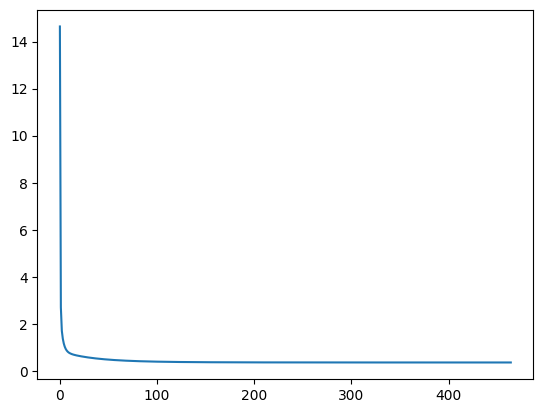

In [34]:
import matplotlib.pyplot as plt


plt.plot(GD.iteration_loss_mse.keys(), GD.iteration_loss_mse.values())